# **CNN & APPLICATIONS**

## **CNN for Text Classification**

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### **Model**

In [3]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

#### **Inference**

In [4]:
def load_model(model_path, num_classes=5):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    img_size = 150

    img_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])
    img_new = img_transform(image)
    img_new = torch.unsqueeze(img_new, 0)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

### **Load dataset**

In [5]:
# !git clone https://github.com/congnghia0609/ntc-scv.git

In [6]:
# !mkdir data

In [7]:
pwd

'e:\\OneDrive\\1.0 DS & AI\\AIO2024\\AIO-Exercise\\Module_06\\Week_01\\TextClassification'

In [8]:
# !tar -xf ./ntc-scv/data/data_test.zip -C ./data  
# !tar -xf ./ntc-scv/data/data_train.zip -C ./data

In [9]:
# !rmdir /S /Q ntc-scv  # Remove the 'ntc-scv' directory and its contents  

In [10]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [11]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

### **Preprocessing**

In [ ]:
# !pip install langid

In [13]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [14]:
train_df_vi, train_df_other = identify_vn(train_df)

In [15]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [16]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

C:\Users\tienn\AppData\Local\Temp\ipykernel_9248\1058621333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [17]:
train_df_vi

,sentence,label,preprocess_sentence
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0,mua có mỗi bingsu thập cẩm k mà mình f đợi hơn...
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0,thứ nào ta cùng quẩy vuvuzela beer club chung ...
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0,mình đi với nhóm tổng cộng người ăn chỉ có khô...
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0,nhân viên phục vụ không mấy tận tình đồ ăn ra ...
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0,vào đây thì hết bàn nhưng mình vẫn ngồi đợi bì...
...,...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1,mình đi với nhóm bạn tổng cộng là ng thiệt hại...
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1,sushi bình dân mà chất lượng không bình dân ch...
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1,trời ơi từ bé đến lớn chưa thử món kem nào bằn...
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1,nge mn cũng ns ngon nên hni đến coi thế nào qu...


### **Representation**

In [18]:
# !pip install torchtext==0.16.0

In [19]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [20]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [21]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [22]:
vocabulary["<pad>"]

0

In [23]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

### **Dataloader**

In [24]:
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [25]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [26]:
next(iter(train_dataloader))

(tensor([[  74, 1787,  197,  ...,   90,  441,    3],
         [ 130,   13,  168,  ...,   48,   32,   38],
         [1064,   94,  267,  ...,   40,  161,  314],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
         0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 1, 1, 1, 0]))

In [27]:
encoded_sentences, labels = next(iter(train_dataloader))

In [28]:
encoded_sentences.shape

torch.Size([367, 128])

### **Model**

In [29]:
import torch.nn as nn
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

In [30]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [31]:
vocab_size

10000

In [32]:
predictions = model(encoded_sentences)
predictions

tensor([[-0.2948, -1.0078],
        [-0.7929, -1.5144],
        [-0.4858, -0.9021],
        [-0.2256, -1.1571],
        [-0.5400, -1.6144],
        [-0.1468, -1.2689],
        [-0.6621, -1.1758],
        [-0.6046, -1.3777],
        [-0.6631, -1.0123],
        [-0.6739, -1.6921],
        [-0.5749, -1.5228],
        [-0.5871, -1.2445],
        [-0.5195, -1.4416],
        [-0.3852, -1.2918],
        [-0.6301, -1.1706],
        [-0.4937, -1.4310],
        [-0.1157, -0.8795],
        [-0.5699, -1.3235],
        [-0.7295, -1.3331],
        [-0.8172, -1.4694],
        [-0.8397, -1.7038],
        [-0.3908, -1.2022],
        [-0.3662, -1.2136],
        [-0.4188, -1.0811],
        [-0.3082, -1.0676],
        [-0.6890, -1.1392],
        [-0.6113, -1.4087],
        [-0.3626, -1.2360],
        [-0.6375, -1.2151],
        [-0.4598, -1.2943],
        [-0.3975, -0.7623],
        [-0.6577, -1.4634],
        [-0.5324, -1.4252],
        [-0.2686, -1.2795],
        [-0.7038, -1.1503],
        [-0.6876, -1

In [33]:
predictions.shape

torch.Size([128, 2])

### **Loss & Optimizer**

In [34]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [35]:
loss = criterion(predictions, labels)
loss

tensor(0.7989, grad_fn=<NllLossBackward0>)

### **Trainer**

In [36]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [37]:
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [38]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  233 batches | accuracy    0.757
| epoch   0 |   100/  233 batches | accuracy    0.848
| epoch   0 |   150/  233 batches | accuracy    0.862
| epoch   0 |   200/  233 batches | accuracy    0.876


In [39]:
epoch_acc, epoch_loss

(0.8807385229540918, 0.37276209762935475)

In [40]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [41]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)

In [42]:
eval_acc, eval_loss

(0.8755, 0.3110328831627399)

### **Training**

In [43]:
import torch.nn.functional as F

In [45]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        print('Save model at ./model/text_cnn_model.pt')
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

| epoch   1 |    50/  233 batches | accuracy    0.680
| epoch   1 |   100/  233 batches | accuracy    0.828
| epoch   1 |   150/  233 batches | accuracy    0.851
| epoch   1 |   200/  233 batches | accuracy    0.863
Save model at ./model/text_cnn_model.pt
-----------------------------------------------------------
| End of epoch   1 | Time: 135.22s | Train Accuracy    0.866 | Train Loss    0.428 | Valid Accuracy    0.866 | Valid Loss    0.333 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.898
| epoch   2 |   100/  233 batches | accuracy    0.904
| epoch   2 |   150/  233 batches | accuracy    0.899
| epoch   2 |   200/  233 batches | accuracy    0.898
Save model at ./model/text_cnn_model.pt
-----------------------------------------------------------
| End of epoch   2 | Time: 136.23s | Train Accuracy    0.902 | Train Loss    0.269 | Valid Accuracy    0.884 | Valid Loss    0.296 
--------------------------------------------

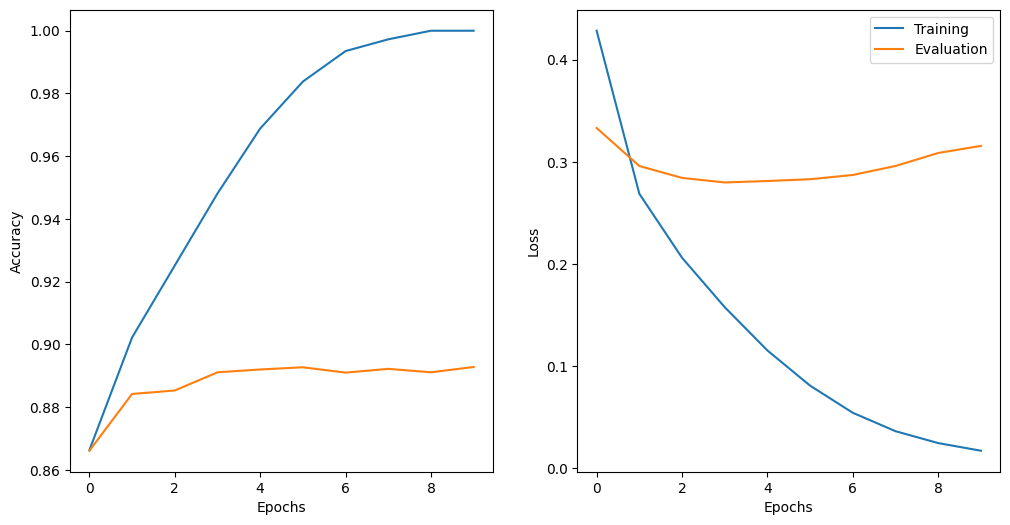

In [46]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

### **Evaluation & Prediction**

In [47]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [48]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [49]:
test_acc, test_loss = evaluate(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8982, 0.2946922394293773)

### **Inference**

In [50]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=300, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def inference(sentence, vocabulary, model):
    sentence = preprocess_text(sentence)
    encoded_sentence = vocabulary(tokenizer(sentence))
    encoded_sentence = torch.tensor(encoded_sentence)
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        predictions = model(encoded_sentence)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, yhat.item()

In [51]:
torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

In [52]:
model = load_model('./model/text_cnn_model.pt')
inference(test_df['preprocess_sentence'][5999], vocabulary, model)

(90.0, 1)

In [53]:
test_df

,sentence,label,preprocess_sentence
0,Quán này khá là nổi_tiếng nay mới có dịp ghé t...,0,quán này khá là nổi tiếng nay mới có dịp ghé t...
1,"Đây là lần đầu_tiên mình ăn_ở đây , và có_lẽ c...",0,đây là lần đầu tiên mình ăn ở đây và có lẽ cũn...
2,tha ́ i đô ̣ phu ̣ c vu ̣ nhân_viên không tô ́...,0,tha ́ i đô ̣ phu ̣ c vu ̣ nhân viên không tô ́...
3,Đồ_ăn bình_thường . Cần chăm_chút không_gian h...,0,đồ ăn bình thường cần chăm chút không gian hơn...
4,"Phục_vụ lâu , giá thì ổn thôi nhưng chất_lượng...",0,phục vụ lâu giá thì ổn thôi nhưng chất lượng b...
...,...,...,...
9995,"Gia re , mon an ngon , view dep va nhan vien n...",1,gia re mon an ngon view dep va nhan vien nhiet...
9996,"Quán nằm trên đường Thạch_Thị_Thanh , dễ tìm ....",1,quán nằm trên đường thạch thị thanh dễ tìm khô...
9997,Mình đã đến ăn_ở quán này vài lần . Đồ_ăn ngon...,1,mình đã đến ăn ở quán này vài lần đồ ăn ngon g...
9998,Nhà_hàng trang_trí độc_đáo .\n Món ăn mới_lạ n...,1,nhà hàng trang trí độc đáo món ăn mới lạ nhiều...


In [54]:
inference('Đồ ăn rất ngon và rẻ', vocabulary, model)

(78.0, 0)

In [55]:
test_df['preprocess_sentence'][5999]

'ghé tiệm mua mấy cái bánh bao mà thấy bánh làm theo mùa noel nó đẹp gì đâu ak nhìn ưng quá giá có k một cái rẻ thôi rồi'